In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import keras.layers
import os
import cv2
import glob as gb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def load_images_from_directory(directory_path, target_size=(200, 200), batch_size=8):


    datagen = ImageDataGenerator(rescale=1./255)  # reserve a fraction of images for validation

    train_generator = datagen.flow_from_directory(
        directory_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    return train_generator

# Example usage:
directory_path = '/content/drive/MyDrive/PLASTIC DEFECT/train'
train_gen = load_images_from_directory(directory_path)

test_path = '/content/drive/MyDrive/PLASTIC DEFECT/test'
test_gen = load_images_from_directory(test_path, batch_size=1)



In [ ]:
code = {'crazing':0 ,'inclusion':1,'patches':2,'pitted_surface':3,'rolled-in_scale':4,'scratches':5}

In [ ]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [ ]:
all_features = []
all_labels = []

# Number of batches
steps = len(train_gen)

for i in range(steps):
    batch_images, batch_labels = next(train_gen)
    print("Processing batch:", i + 1)
    batch_features = base_model.predict(batch_images)
    all_features.append(batch_features)
    all_labels.append(batch_labels)



In [ ]:
test_features = []
test_labels = []

# Number of batches
steps = len(test_gen)

for i in range(steps):
    batch_images, batch_labels = next(test_gen)
    print("Processing batch:", i + 1)
    batch_features = base_model.predict(batch_images)
    test_features.append(batch_features)
    test_labels.append(batch_labels)


In [ ]:
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_features = np.reshape(all_features, (all_features.shape[0], -1))
all_labels = np.argmax(all_labels, axis=1)

In [ ]:
all_features.shape

In [ ]:
all_labels.shape

In [8]:
test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)
test_features = np.reshape(test_features, (test_features.shape[0], -1))
test_labels = np.argmax(test_labels, axis=1)

In [9]:
test_features.shape

(60, 18432)

In [10]:
test_labels.shape

(60,)

In [23]:
!pip install -U scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


In [ ]:

features_path = '/content/drive/MyDrive/all_features.npy'
labels_path = '/content/drive/MyDrive/all_labels.npy'

# Save the files
np.save(features_path, all_features)
np.save(labels_path, all_labels)


NameError: ignored

In [ ]:
all_labels = np.load("/content/drive/MyDrive/PLASTIC DEFECT/all_labels.npy")
all_features = np.load("/content/drive/MyDrive/PLASTIC DEFECT/all_features.npy")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [ ]:
all_features.shape

(1380, 18432)

In [ ]:
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_search = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_search.fit(all_features, all_labels)

KeyboardInterrupt: ignored

In [ ]:
dtc_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

dtc_search = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5)
dtc_search.fit(all_features, all_labels)

In [ ]:
lda_params = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto']
}
lda_search = GridSearchCV(LinearDiscriminantAnalysis(), lda_params, cv=5)
lda_search.fit(all_features, all_labels)

In [ ]:
gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

gnb_search = GridSearchCV(GaussianNB(), gnb_params, cv=5)
gnb_search.fit(all_features, all_labels)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]})

In [ ]:
# Parameters to be tested for SVM
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

svm_search = GridSearchCV(SVC(), svm_params, cv=5, verbose=2, n_jobs=-1)
svm_search.fit(all_features, all_labels)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


KeyboardInterrupt: ignored

In [ ]:
# K-Nearest Neighbors

KNN = knn_search.best_estimator_
KNN.fit(all_features, all_labels)

# Decision Tree
DTC = dtc_search.best_estimator_
DTC.fit(all_features, all_labels)


# Linear Discriminant Analysis
LDA = lda_search.best_estimator_
LDA.fit(all_features, all_labels)

# Gaussian Naive Bayes
GNB = gnb_search.best_estimator_
GNB.fit(all_features, all_labels)



GaussianNB(var_smoothing=1e-07)

In [ ]:

# Predictions
KNN_preds = KNN.predict(test_features)
DTC_preds = DTC.predict(test_features)
LDA_preds = LDA.predict(test_features)
GNB_preds = GNB.predict(test_features)
SVM_preds = SVM.predict(test_features)

# Calculate accuracy for each model
KNN_accuracy = accuracy_score(test_labels, KNN_preds)
DTC_accuracy = accuracy_score(test_labels, DTC_preds)
LDA_accuracy = accuracy_score(test_labels, LDA_preds)
GNB_accuracy = accuracy_score(test_labels, GNB_preds)
SVM_accuracy = accuracy_score(test_labels, SVM_preds)

# Print accuracies
print(f"KNN Accuracy: {KNN_accuracy}")
print(f"Decision Tree Accuracy: {DTC_accuracy}")
print(f"LDA Accuracy: {LDA_accuracy}")
print(f"Naive Bayes Accuracy: {GNB_accuracy}")
print(f"SVM Accuracy: {SVM_accuracy}")

# Calculate and display confusion matrices
KNN_cm = confusion_matrix(test_labels, KNN_preds)
DTC_cm = confusion_matrix(test_labels, DTC_preds)
LDA_cm = confusion_matrix(test_labels, LDA_preds)
GNB_cm = confusion_matrix(test_labels, GNB_preds)
SVM_cm = confusion_matrix(test_labels, SVM_preds)

print("\nKNN Confusion Matrix:")
print(KNN_cm)

print("\nDecision Tree Confusion Matrix:")
print(DTC_cm)

print("\nLDA Confusion Matrix:")
print(LDA_cm)

print("\nNaive Bayes Confusion Matrix:")
print(GNB_cm)

print("\nSVM Confusion Matrix:")
print(SVM_cm)


KNN Accuracy: 0.95
Decision Tree Accuracy: 0.7833333333333333
LDA Accuracy: 0.9333333333333333
Naive Bayes Accuracy: 0.7833333333333333
SVM Accuracy: {1.0}


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def conf_matrix(model, model_name):
    model_preds = model.predict(test_features)
    model_cm = confusion_matrix(test_labels, model_preds)

    plt.figure(figsize=(10,7))
    sns.heatmap(model_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches'], yticklabels=['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name + ' Confusion Matrix')
    plt.show()

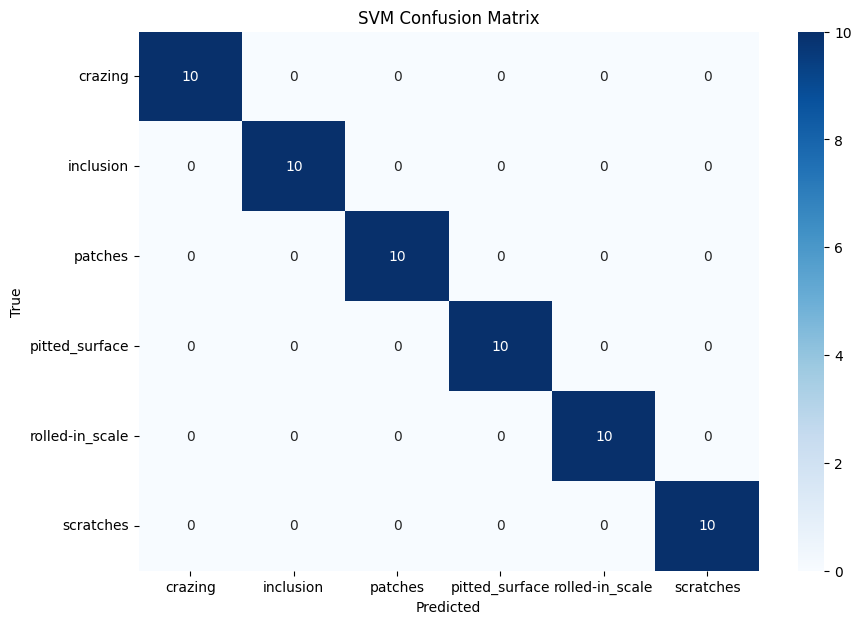

In [ ]:
conf_matrix(SVM, 'SVM')

In [ ]:
import pickle

# Your trained model
# Save the trained model as a pickle string
with open('saved_model.pkl', 'wb') as file:
    pickle.dump(SVM, file)


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
from PIL import Image

In [ ]:
segment_model = YOLO("/content/drive/MyDrive/segmentation_improved.pt")

In [ ]:
code = {v: k for k, v in code.items()}

In [ ]:
final_model = SVM

In [ ]:
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import keras.layers
import os
import cv2
import glob as gb

final_model = SVM # loaded from pickle
#base_model = VGG_model # loaded from pickle
#segment_model = YOLO(weights_path)

code = {0: 'crazing', 1: 'inclusion', 2: 'patches', 3: 'pitted_surface', 4: 'rolled-in_scale', 5: 'scratches'}

def deployment_function(image_path):

    image = cv2.imread(image_path)
    normalized_image = image / 255
    normalized_image = normalized_image.reshape((1, 200, 200, 3))
    features = base_model.predict(normalized_image)
    pred = np.reshape(features, (features.shape[0], -1))
    final_pred = final_model.predict(pred)
    predicted_class = code[int(final_pred)]


    if predicted_class != 'crazing' and predicted_class != 'pitted_surface':
        results = segment_model(image, conf=0.1)
        image_to_plot = results[0].plot(masks=True, boxes=False)
    else:
        image_to_plot = image

    image_to_plot = cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB)

    # Plot the image on the current axis
    plt.imshow(image_to_plot)
    plt.title(predicted_class)
    plt.show()
    plt.imshow(image)
    plt.title("Original Image")
    plt.show()

1/1 [==============================] - 0s 18ms/step



0: 224x224 4 Defectss, 12.8ms
Speed: 1.2ms preprocess, 12.8ms inference, 11.6ms postprocess per image at shape (1, 3, 224, 224)


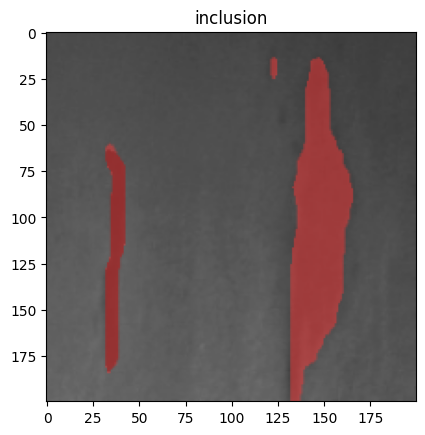

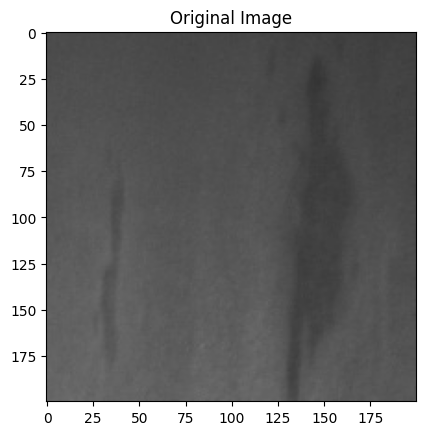

In [ ]:
deployment_function('/content/drive/MyDrive/PLASTIC DEFECT/test/inclusion/inclusion_205.jpg')

1/1 [==============================] - 0s 26ms/step



0: 224x224 2 Defectss, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 4.3ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 34ms/step



0: 224x224 2 Defectss, 9.3ms
Speed: 0.9ms preprocess, 9.3ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 25ms/step



0: 224x224 6 Defectss, 20.4ms
Speed: 0.8ms preprocess, 20.4ms inference, 5.0ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 31ms/step



0: 224x224 10 Defectss, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 30ms/step



0: 224x224 16 Defectss, 9.2ms
Speed: 0.9ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 27ms/step



0: 224x224 2 Defectss, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 25ms/step



0: 224x224 3 Defectss, 9.2ms
Speed: 0.8ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 27ms/step



0: 224x224 17 Defectss, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 29ms/step



0: 224x224 6 Defectss, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 26ms/step



0: 224x224 7 Defectss, 9.7ms
Speed: 4.3ms preprocess, 9.7ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 26ms/step



0: 224x224 1 Defects, 10.0ms
Speed: 1.1ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 28ms/step



0: 224x224 5 Defectss, 13.4ms
Speed: 1.5ms preprocess, 13.4ms inference, 5.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 56ms/step



0: 224x224 3 Defectss, 20.4ms
Speed: 0.9ms preprocess, 20.4ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 28ms/step



0: 224x224 10 Defectss, 11.5ms
Speed: 0.9ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 37ms/step



0: 224x224 11 Defectss, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 32ms/step



0: 224x224 2 Defectss, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 7.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 30ms/step



0: 224x224 1 Defects, 25.9ms
Speed: 1.0ms preprocess, 25.9ms inference, 3.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 27ms/step



0: 224x224 4 Defectss, 18.0ms
Speed: 0.9ms preprocess, 18.0ms inference, 6.8ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 31ms/step



0: 224x224 12 Defectss, 11.4ms
Speed: 0.9ms preprocess, 11.4ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 47ms/step



0: 224x224 7 Defectss, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 43ms/step



0: 224x224 2 Defectss, 20.2ms
Speed: 1.2ms preprocess, 20.2ms inference, 9.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 27ms/step



0: 224x224 2 Defectss, 29.5ms
Speed: 0.9ms preprocess, 29.5ms inference, 7.8ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 49ms/step



0: 224x224 4 Defectss, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 7.3ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 47ms/step



0: 224x224 3 Defectss, 12.2ms
Speed: 0.9ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 27ms/step



0: 224x224 1 Defects, 12.4ms
Speed: 0.8ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 50ms/step



0: 224x224 10 Defectss, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 4.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 32ms/step



0: 224x224 5 Defectss, 19.6ms
Speed: 1.2ms preprocess, 19.6ms inference, 7.1ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 30ms/step



0: 224x224 6 Defectss, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 27ms/step



0: 224x224 5 Defectss, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 25ms/step



0: 224x224 12 Defectss, 10.6ms
Speed: 1.4ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 26ms/step



0: 224x224 1 Defects, 13.3ms
Speed: 0.8ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 24ms/step



0: 224x224 2 Defectss, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 28ms/step



0: 224x224 1 Defects, 9.3ms
Speed: 0.8ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 26ms/step



0: 224x224 2 Defectss, 10.7ms
Speed: 1.4ms preprocess, 10.7ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 25ms/step



0: 224x224 3 Defectss, 9.3ms
Speed: 4.1ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 26ms/step



0: 224x224 1 Defects, 9.9ms
Speed: 1.2ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 26ms/step



0: 224x224 8 Defectss, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 29ms/step



0: 224x224 3 Defectss, 10.4ms
Speed: 7.8ms preprocess, 10.4ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 28ms/step



0: 224x224 4 Defectss, 9.7ms
Speed: 1.0ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 27ms/step



0: 224x224 17 Defectss, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 224, 224)


1/1 [==============================] - 0s 26ms/step


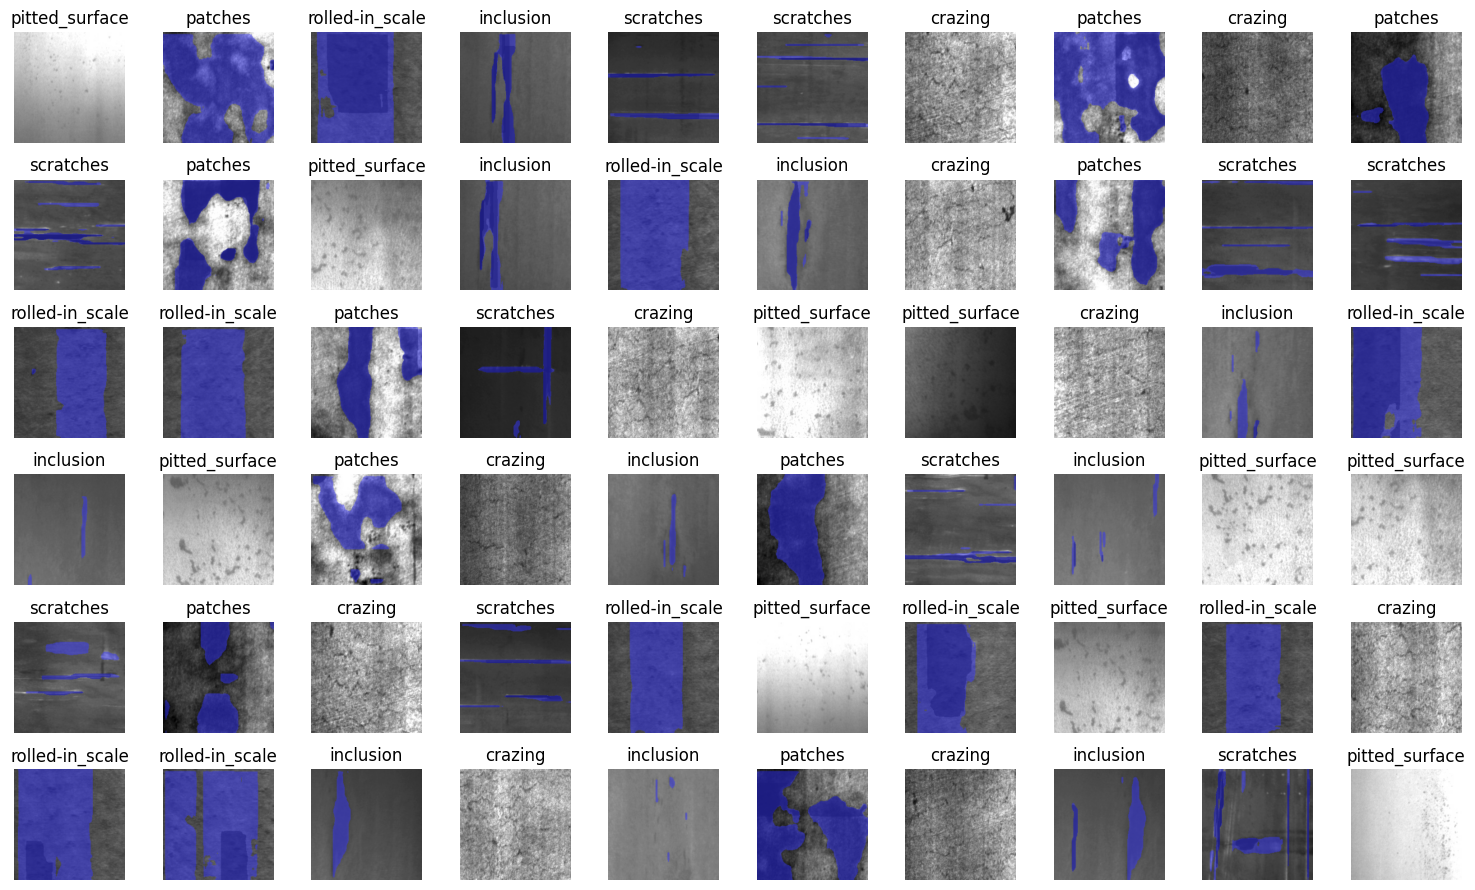

In [ ]:

steps = len(test_gen)


fig, axes = plt.subplots(6, 10, figsize=(15, 9))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the 2D list of axes

for i in range(steps):
    batch_images, batch_labels = next(test_gen)
    image_to_plot = batch_images.reshape(200, 200, 3)
    batch_features = base_model.predict(batch_images)
    pred = np.reshape(batch_features, (batch_features.shape[0], -1))
    final_pred = final_model.predict(pred)
    predicted_class = code[int(final_pred)]


    if predicted_class != 'crazing' and predicted_class != 'pitted_surface':
        image_to_plot = (image_to_plot * 255).astype(np.uint8)
        results = segment_model(image_to_plot, conf=0.1)
        image_to_plot = results[0].plot(masks=True, boxes=False)


    # Plot the image on the current axis
    axes[i].imshow(image_to_plot, cmap='Reds')
    axes[i].set_title(predicted_class)
    axes[i].axis('off')

# Display the entire grid of images
plt.tight_layout()
plt.show()

In [ ]:
code

{0: 'crazing',
 1: 'inclusion',
 2: 'patches',
 3: 'pitted_surface',
 4: 'rolled-in_scale',
 5: 'scratches'}